 In this notebook, we export to .shp files the duplicated precincts in the LA times precincts data to view them in QGIS. 
 2 "versions" are exported:
 - the simple "subshapefile" of the duplicates
 - a shapefile with only one entry per precinct, with area computed as the sum of all areas (note that this might be an approximation rather than the exact area as we did not handle overlaps), and geometry as the multipolygon composed of all polygons associated to a precinct.

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd


In [2]:
precincts = gpd.read_file('./Data/LAtimes2016_merged/merged_CA2016.shp')

In [3]:
dups = precincts[precincts.duplicated('pct16', keep =False)== True]

In [27]:
#save duplicates shapefile - for QGIS use
dups.to_file("LA_times_duplicates.shp")

Now we will group all the duplicates in one line for each precinct. 
Changes to make to obtain this file:
- turn the polygon pieces into a single multipolygon object for each county ID. 
- compute the area, being careful about overlaps of precinct pieces (for now, we only care about geometry, and can actually obtain area from the geometry, so the simple approximation of summing all areas of the pieces corresponding to one precinct will be used in the first place)


In [12]:
areas = dups.groupby('pct16').agg({'area':'sum'})

In [13]:
duplicates = dups[['pct16']].drop_duplicates('pct16', keep = 'first')

In [29]:
len(duplicates), len(areas)
#difference is due to 'None' precinct... 

(691, 690)

In [18]:
duplicates = duplicates.join(areas, on = 'pct16')

In [30]:
from shapely.ops import cascaded_union

In [31]:
duplicates['geometry'] = 0

In [46]:

df = dups[dups['pct16'] == '071-RAN1050']
geoms = df['geometry'].to_list()
geom = gpd.GeoSeries(cascaded_union(geoms))

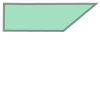

In [48]:
geom[0]

In [56]:
for index, row in duplicates.iterrows():
    
    precinct = row['pct16']
    if not precinct is None :
        try : 
            df = dups[dups['pct16'] == precinct]
            geoms = df['geometry'].to_list()
            geom = gpd.GeoSeries(cascaded_union(geoms))
            duplicates['geometry'][index] = geom[0]
        except:
            print('you should check precinct')
            print(precinct)
    

C:\Users\Mélisande\Anaconda3\envs\VRDI\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


you should check precinct
085-0


In [57]:
dups[dups.pct16 == '085-0']

,area,pct16,geometry
22541,NaN,085-0,None
22659,NaN,085-0,None
22660,NaN,085-0,None
22675,NaN,085-0,None
22684,NaN,085-0,None


In [65]:
duplicates['area'][1309] = dups['area'][1309]
duplicates['geometry'][1309] = dups['geometry'][1309]

C:\Users\Mélisande\Anaconda3\envs\VRDI\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Mélisande\Anaconda3\envs\VRDI\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [68]:
duplicates[duplicates.pct16 == '085-0']['geometry'] = np.nan

C:\Users\Mélisande\Anaconda3\envs\VRDI\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [73]:

duplicates = gpd.GeoDataFrame(duplicates, geometry='geometry')
duplicates.to_file("LA_times_duplicates_agg.shp")